# Set up

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from pathlib import Path
import matplotlib.pyplot as plt
import os

2024-04-01 20:59:45.658594: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Generating Shakespearean Text Using a Character RNN 

## Creating the Training Dataset

In [3]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url, cache_dir=".")
with open(filepath) as f:
    shakespeare_text = f.read()

In [4]:
# Extra code shows a short text sample
print(shakespeare_text[:80])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [5]:
# Extra code shows all 39 distinct characters (after converting to lower case)
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [6]:
text_vec_layer = tf.keras.layers.TextVectorization(
    split="character", standardize="lower"
)
text_vec_layer.adapt([shakespeare_text])
encoded = text_vec_layer([shakespeare_text])[0]

2024-03-29 19:39:40.078889: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
encoded -= 2  # drop tokens 0 (pad) and 1 (unknown), which we will not use
n_tokens = text_vec_layer.vocabulary_size() - 2  # number of distinct chars = 39
dataset_size = len(encoded)  # total number of chars = 1,115,394

In [8]:
n_tokens

39

In [9]:
dataset_size

1115394

In [10]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(100_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [11]:
list(to_dataset(text_vec_layer(["To be"])[0], length=4))

2024-03-29 19:39:40.617616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [5]
	 [[{{node Placeholder/_0}}]]
2024-03-29 19:39:40.617783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [5]
	 [[{{node Placeholder/_0}}]]


[(<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 4,  5,  2, 23]])>,
  <tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 5,  2, 23,  3]])>)]

In [12]:
length = 100
tf.random.set_seed(42)
train_set = to_dataset(encoded[:1_000_000], length=length, shuffle=True, seed=42)
valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)
test_set = to_dataset(encoded[1_060_000:], length=length)

## Building and Training the Char-RNN Model


**Warning**: the following code may take one or two hours to run, depending on your GPU. Without GPU, it may take over 24 hours. This is why I won't bother training it, instead I will use  pretrained one from the author.

**Note**: The `GRU` class will only use cuDNN acceleration (assuming you have a GPU with CUDA) when using the default values for the following arguments: `activation`, `recurrent_activation`, `recurrent_dropout`, `dropout`, `unroll`, `use_bias` and `reset_after`. Read the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) for more details.

```python
tf.random.set_seed(42)
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
        tf.keras.layers.GRU(128, return_sequences=True),
        tf.keras.layers.Dense(n_tokens, activation="softmax"),
    ]
)
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('my_shakespeare_model', monitor='val_accuracy', save_best_only=True)
history = model.fit(train_set, validation_data=valid_set, epochs=10, callbacks=[model_checkpoint])
```

```python
shakespeare_model = tf.keras.Sequential([
    text_vec_layer, # adapted layer
    tf.keras.layers.Lambda(lambda X: X-2), # no <PAD> or <UNK> tokens
    model
])
```

In [12]:
# extra code downloads a pretrained model
url = "https://github.com/ageron/data/raw/main/shakespeare_model.tgz"
path = tf.keras.utils.get_file(
    "shakespeare_model.tgz", url, extract=True, cache_dir="."
)
model_path = Path(path).with_name("shakespeare_model")
shakespeare_model: tf.keras.Model = tf.keras.models.load_model(model_path)

2024-03-29 09:30:16.417435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2024-03-29 09:30:16.417932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2024-03-29 09:30:16.418356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [13]:
y_proba = shakespeare_model.predict(["To be or not to b"])[0, -1]
y_predict = tf.argmax(y_proba)
text_vec_layer.get_vocabulary()[y_predict + 2]

2024-03-29 09:30:21.151741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-29 09:30:21.155286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-29 09:30:21.158637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step


'e'

## Generating Fake Shakespearean Text

In [14]:
log_proba = tf.math.log([[0.5, 0.4, 0.1]])  # proba = 50%, 40%, 10%
tf.random.set_seed(42)
tf.random.categorical(log_proba, num_samples=8)

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 1, 0, 2, 1, 0, 0, 1]])>

The `next_char()` function uses the temperature approach to pick the next character to add to the input text.

In [15]:
def next_char(text, temperature=1):
    y_proba = shakespeare_model.predict([text], verbose=0)[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

Next, we can define another helper function that will repeatedly call `next_char()` to get the next character and append it to the current text.

In [16]:
def extend_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [17]:
tf.random.set_seed(42)
print(extend_text("To be or not to be", temperature=0.01))

To be or not to be the duke
as it is a proper strange death,
and the


In [18]:
print(extend_text("To be or not to be", temperature=1))

To be or not to behold?

second push:
gremio, lord all, a sistermen,


In [19]:
print(extend_text("To be or not to be", temperature=100))

To be or not to bef ,mt'&o3fpadm!$
wh!nse?bws3est--vgerdjw?c-y-ewznq


The last result is not so great. Too much freedom for creativity is not a good choice. You can find some solutions on this problems in note.md.

## Stateful RNN

In [20]:
def to_dataset_for_stateful_rnn(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(size=length + 1, shift=length, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(length + 1).batch(1))
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)


stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000], length)
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_060_000], length)
stateful_test_set = to_dataset_for_stateful_rnn(encoded[1_060_000:], length)

In [21]:
list(to_dataset_for_stateful_rnn(tf.range(10), 3))

2024-03-29 09:30:45.125426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [10]
	 [[{{node Placeholder/_0}}]]
2024-03-29 09:30:45.125820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [10]
	 [[{{node Placeholder/_0}}]]


[(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[0, 1, 2]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[3, 4, 5]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[4, 5, 6]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[6, 7, 8]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[7, 8, 9]], dtype=int32)>)]

You can see that each element in this list is a tuple. In each tuple, the first element is the input sequence, and second is the target sequence.

If you'd like to have more than one window per batch, you can use the `to_batched_dataset_for_stateful_rnn()` function instead of `to_dataset_for_stateful_rnn()`.

In [22]:
def to_non_overlapping_windows(sequence, length):
    data = tf.data.Dataset.from_tensor_slices(sequence)
    data = data.window(length + 1, shift=length, drop_remainder=True)
    return data.flat_map(lambda window: window.batch(length + 1))


def to_batched_dataset_for_stateful_rnn(sequence, length, batch_size=32):
    parts = np.array_split(sequence, batch_size)
    datasets = tuple(to_non_overlapping_windows(part, length) for part in parts)
    ds = tf.data.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [23]:
list(to_batched_dataset_for_stateful_rnn(tf.range(20), 3, batch_size=2))

2024-03-29 09:30:45.390937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [10]
	 [[{{node Placeholder/_0}}]]
2024-03-29 09:30:45.392003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [10]
	 [[{{node Placeholder/_0}}]]


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 0,  1,  2],
         [10, 11, 12]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 1,  2,  3],
         [11, 12, 13]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 3,  4,  5],
         [13, 14, 15]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 4,  5,  6],
         [14, 15, 16]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 6,  7,  8],
         [16, 17, 18]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 7,  8,  9],
         [17, 18, 19]], dtype=int32)>)]

This time, the first element in the tuple is all input sequences of a batch, while the second element is all the corresponding target sequences. 

In [24]:
tf.random.set_seed(42)
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(
            input_dim=n_tokens, output_dim=16, batch_input_shape=[1, None]
        ),
        tf.keras.layers.GRU(128, return_sequences=True, stateful=True),
        tf.keras.layers.Dense(n_tokens, activation="softmax"),
    ]
)

2024-03-29 09:30:46.118365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-29 09:30:46.120323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-29 09:30:46.124693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [25]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [26]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_stateful_shakespeare_model", monitor="val_accuracy", save_best_only=True
)

In [27]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
)
model.fit(
    stateful_train_set,
    validation_data=stateful_valid_set,
    epochs=10,
    callbacks=[model_checkpoint, ResetStatesCallback()],
)

KeyboardInterrupt: 

**Extra Material**: converting the stateful RNN to a stateless RNN and using it.

To use the model with different batch size, we need to create a stateless copy.

In [ ]:
stateless_model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
        tf.keras.layers.GRU(128, return_sequences=True),
        tf.keras.layers.Dense(n_tokens, activation="softmax"),
    ]
)

2024-03-28 22:05:57.719818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-28 22:05:57.720756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-28 22:05:57.721373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

To set the weights, we first need to build the model, so the weights get created.

In [ ]:
stateless_model.build(tf.TensorShape([None, None]))

In [ ]:
stateless_model.set_weights(model.get_weights())

In [ ]:
shakespeare_model = tf.keras.Sequential(
    [text_vec_layer, tf.keras.layers.Lambda(lambda X: X - 2), stateless_model]
)

2024-03-28 22:05:57.864670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-28 22:05:57.865336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-28 22:05:57.866025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
tf.random.set_seed(42)

print(extend_text("to be or not to be", temperature=0.01))

2024-03-28 22:05:58.051270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-28 22:05:58.052194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-28 22:05:58.053260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

to be or not to be so good
and heard him to her heart in her for the


# Sentiment Analysis

In [2]:
raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True,
)

2024-03-31 09:10:08.080428: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
test_set = raw_test_set.batch(32).prefetch(1)

In [4]:
for review, label in raw_train_set.take(4):
    print(review.numpy().decode("utf-8")[:200], "...")
    print("Label:", label.numpy())

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0
Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Moun ...
Label: 0
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful perf ...
Label: 1


2024-03-31 09:10:10.160291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-03-31 09:10:10.160760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-03-31 09:10:10.222992: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

In [5]:
vocab_size = 1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_set.map(lambda reviews, labels: reviews))

2024-03-31 09:10:11.151926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-03-31 09:10:11.152398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


**Warning**: the following cell will take a few minutes to run and the model will probably not learn anything because we did't mask the padding tokens (that's the point of the next section).

In [33]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential(
    [
        text_vec_layer,
        tf.keras.layers.Embedding(vocab_size, embed_size),
        tf.keras.layers.GRU(128),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=2)

Epoch 1/2


2024-03-29 10:01:49.331232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-29 10:01:49.332042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-29 10:01:49.332791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

704/704 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5018

2024-03-29 10:06:02.143581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-03-29 10:06:02.143927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2024-03-29 10:06:02.328230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dt

704/704 [==============================] - 264s 372ms/step - loss: 0.6935 - accuracy: 0.5018 - val_loss: 0.6931 - val_accuracy: 0.5016
Epoch 2/2
704/704 [==============================] - 249s 353ms/step - loss: 0.6927 - accuracy: 0.5050 - val_loss: 0.6935 - val_accuracy: 0.4996


## Masking

In [21]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential(
    [
        text_vec_layer,
        tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_size, mask_zero=True
        ),
        tf.keras.layers.GRU(128),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
704/704 [==============================] - ETA: 0s - loss: 0.4927 - accuracy: 0.7581

2024-03-29 19:49:37.110315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-03-29 19:49:37.110682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


704/704 [==============================] - 307s 432ms/step - loss: 0.4927 - accuracy: 0.7581 - val_loss: 0.3835 - val_accuracy: 0.8356
Epoch 2/5
704/704 [==============================] - 332s 472ms/step - loss: 0.3304 - accuracy: 0.8605 - val_loss: 0.3147 - val_accuracy: 0.8716
Epoch 3/5
704/704 [==============================] - 346s 492ms/step - loss: 0.2864 - accuracy: 0.8821 - val_loss: 0.3342 - val_accuracy: 0.8612
Epoch 4/5
704/704 [==============================] - 350s 497ms/step - loss: 0.2668 - accuracy: 0.8908 - val_loss: 0.3075 - val_accuracy: 0.8644
Epoch 5/5
704/704 [==============================] - 342s 486ms/step - loss: 0.2508 - accuracy: 0.8990 - val_loss: 0.3132 - val_accuracy: 0.8600


In [23]:
tf.random.set_seed(42)
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
token_ids = text_vec_layer(inputs)
mask = tf.math.not_equal(token_ids, 0)
Z = tf.keras.layers.Embedding(vocab_size, embed_size)(token_ids)
Z = tf.keras.layers.GRU(128, dropout=0.2)(Z, mask=mask)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(Z)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [24]:
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
704/704 [==============================] - 361s 509ms/step - loss: 0.4932 - accuracy: 0.7542 - val_loss: 0.4348 - val_accuracy: 0.8052
Epoch 2/5
704/704 [==============================] - 333s 474ms/step - loss: 0.3734 - accuracy: 0.8332 - val_loss: 0.3156 - val_accuracy: 0.8660
Epoch 3/5
704/704 [==============================] - 364s 518ms/step - loss: 0.2985 - accuracy: 0.8767 - val_loss: 0.3060 - val_accuracy: 0.8744
Epoch 4/5
704/704 [==============================] - 437s 620ms/step - loss: 0.2746 - accuracy: 0.8883 - val_loss: 0.3216 - val_accuracy: 0.8604
Epoch 5/5
704/704 [==============================] - 356s 505ms/step - loss: 0.2592 - accuracy: 0.8949 - val_loss: 0.3134 - val_accuracy: 0.8636


**Exert material: using ragged tensors**

In [26]:
text_vec_layer_ragged = tf.keras.layers.TextVectorization(vocab_size, ragged=True)
text_vec_layer_ragged.adapt(train_set.map(lambda reviews, labels: reviews))
text_vec_layer_ragged([["Great Movie"], ["I don't really like it"]])

2024-03-29 20:49:53.461345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-03-29 20:49:53.461971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


<tf.RaggedTensor [[86, 18], [10, 90, 63, 39, 9]]>

In [28]:
text_vec_layer([["Great Movie"], ["I don't really like it"]])

<tf.Tensor: shape=(2, 5), dtype=int64, numpy=
array([[86, 18,  0,  0,  0],
       [10, 90, 63, 39,  9]])>

In [29]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential(
    [
        text_vec_layer_ragged,
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size),
        tf.keras.layers.GRU(128),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5


2024-03-29 20:56:01.940185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-29 20:56:01.941133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-29 20:56:01.942143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

704/704 [==============================] - ETA: 0s - loss: 0.5199 - accuracy: 0.7346

2024-03-29 21:01:57.662672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-29 21:01:57.663653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-29 21:01:57.664971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

704/704 [==============================] - 368s 521ms/step - loss: 0.5199 - accuracy: 0.7346 - val_loss: 0.4696 - val_accuracy: 0.8040
Epoch 2/5
704/704 [==============================] - 304s 432ms/step - loss: 0.3337 - accuracy: 0.8563 - val_loss: 0.3134 - val_accuracy: 0.8676
Epoch 3/5
704/704 [==============================] - 290s 412ms/step - loss: 0.2866 - accuracy: 0.8807 - val_loss: 0.3022 - val_accuracy: 0.8712
Epoch 4/5
704/704 [==============================] - 300s 426ms/step - loss: 0.2674 - accuracy: 0.8901 - val_loss: 0.3127 - val_accuracy: 0.8660
Epoch 5/5
704/704 [==============================] - 277s 394ms/step - loss: 0.2464 - accuracy: 0.9012 - val_loss: 0.3170 - val_accuracy: 0.8624


## Reusing Pretrained Embeddings and Language Models

The following code cell run way too long (up to 10 hours using my CPU, and more if use Colab), hence I won't run it. May be later when I have a GPU.

```python
os.environ["TFHUB_CACHE_DIR"] = "my_tfhub_cache"
tf.random.set_seed(42)
model = tf.keras.Sequential(
    [
        hub.KerasLayer(
            "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/tensorFlow2/variations/universal-sentence-encoder/versions/2?tfhub-redirect=true",
            trainable=True,
            dtype=tf.string,
            input_shape=[],
        ),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(train_set, validation_data=valid_set, epochs=10)
```

# An Encoder-Decoder Network for Neural Machine Translation

In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file(
    "spa-eng.zip", origin=url, cache_dir="datasets", extract=True
)
text = (Path(path).with_name("spa-eng") / "spa.txt").read_text()

In [3]:
text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)
np.random.shuffle(pairs)
sentence_en, sentence_es = zip(*pairs)  # separates the pairs into 2 lists

In [4]:
for i in range(3):
    print(sentence_en[i], "=>", sentence_es[i])

How boring! => Qué aburrimiento!
I love sports. => Adoro el deporte.
Would you like to swap jobs? => Te gustaría que intercambiemos los trabajos?


In [5]:
vocab_size = 1000
max_length = 50
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length
)
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length
)
text_vec_layer_en.adapt(sentence_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentence_es])

2024-04-01 20:59:53.631773: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']

In [7]:
text_vec_layer_es.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']

In [8]:
X_train = tf.constant(sentence_en[:100_000])
X_valid = tf.constant(sentence_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentence_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentence_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentence_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentence_es[100_000:]])

In [9]:
tf.random.set_seed(42)
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [10]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(
    vocab_size, embed_size, mask_zero=True
)
decoder_embedding_layer = tf.keras.layers.Embedding(
    vocab_size, embed_size, mask_zero=True
)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [11]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

In [12]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [13]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
y_proba = output_layer(decoder_outputs)

**Warning**: the code cell below takes up to 3 hours to run on my CPU, so I will train it once, and save it. 

In [14]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[y_proba])
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
)
model.fit(
    (X_train, X_train_dec),
    Y_train,
    epochs=10,
    validation_data=((X_valid, X_valid_dec), Y_valid),
)

Epoch 1/10
3125/3125 [==============================] - 1074s 342ms/step - loss: 2.8754 - accuracy: 0.4409 - val_loss: 2.1099 - val_accuracy: 0.5359
Epoch 2/10
3125/3125 [==============================] - 981s 314ms/step - loss: 1.7867 - accuracy: 0.5886 - val_loss: 1.5942 - val_accuracy: 0.6237
Epoch 3/10
3125/3125 [==============================] - 976s 312ms/step - loss: 1.3756 - accuracy: 0.6627 - val_loss: 1.3711 - val_accuracy: 0.6676
Epoch 4/10
3125/3125 [==============================] - 985s 315ms/step - loss: 1.1457 - accuracy: 0.7079 - val_loss: 1.2827 - val_accuracy: 0.6851
Epoch 5/10
3125/3125 [==============================] - 1074s 344ms/step - loss: 0.9832 - accuracy: 0.7406 - val_loss: 1.2536 - val_accuracy: 0.6908
Epoch 6/10
3125/3125 [==============================] - 969s 310ms/step - loss: 0.8503 - accuracy: 0.7693 - val_loss: 1.2497 - val_accuracy: 0.6936
Epoch 7/10
3125/3125 [==============================] - 1059s 339ms/step - loss: 0.7383 - accuracy: 0.7948 - v

In [15]:
tf.keras.models.save_model(model, "my_encoder_decoder_nmt")

2024-03-30 23:33:42.918550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-30 23:33:42.919689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-30 23:33:42.920474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: my_encoder_decoder_nmt/assets


INFO:tensorflow:Assets written to: my_encoder_decoder_nmt/assets


In [14]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input
        X_dec = np.array(["startofseq" + translation])  # decoder input
        y_proba = model.predict((X, X_dec), verbose=0)[0, word_idx]  # last toke's proba
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation

In [25]:
translate("I like soccer")

' me gusta el fútbol'

Nice! But the model struggles with longer sentences.

In [26]:
translate("I like soccer and also going to the beach")

' me gusta el fútbol no viene al café o no'

## Bidirectional RNNs

In [41]:
tf.random.set_seed(42)
encoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_state=True))

In [42]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [
    tf.concat(encoder_state[::2], axis=-1),  # short-term (0 and 2)
    tf.concat(encoder_state[1::2], axis=-1),  # long-term (1 and 3)
]

In [43]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
y_proba = output_layer(decoder_outputs)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[y_proba])
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
)

Here is my workaround for the CPU to run: This model requires roughly 60-80% CPU, run continuously for roughly 2 and a half hours, which makes it extremely hot. So at the end of every epoch, except the last one, I let the CPU sleep for 120 seconds to let it cool down a bit (hopefully). If you have a good enough GPU, you can omit it entirely, change the `epochs` to 10 and merge with the previous cell.

In [45]:
for i in range(10):
    model.fit(
        (X_train, X_train_dec),
        Y_train,
        epochs=1,
        validation_data=((X_valid, X_valid_dec), Y_valid),
    )
    if i < 9:
        from time import sleep

        sleep(120)  # wait for 2 minute for the CPU to cool down

3125/3125 [==============================] - 790s 253ms/step - loss: 0.5316 - accuracy: 0.8472 - val_loss: 1.5374 - val_accuracy: 0.6639


In [46]:
translate("I like soccer")

' me gusta el fútbol'

In [47]:
translate("I like soccer and also going to the beach")

' me gusta el [UNK] [UNK] que [UNK] a la playa'

In [48]:
tf.keras.models.save_model(model, "my_bidirectional_nmt")

2024-03-31 17:56:10.303999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-31 17:56:10.304804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-31 17:56:10.306284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: my_bidirectional_nmt/assets


INFO:tensorflow:Assets written to: my_bidirectional_nmt/assets


In [15]:
model = tf.keras.models.load_model("my_bidirectional_nmt")

2024-03-31 18:10:16.795477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_reversev2_grad_reversev2_reversev2_axis' with dtype int32 and shape [1]
	 [[{{node gradients_reversev2_grad_reversev2_reversev2_axis}}]]
2024-03-31 18:10:16.796210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2024-03-31 18:10:16.796248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

## Beam Search

In [15]:
def beam_search(sentence_en, beam_width, verbose=False):
    X = np.array([sentence_en])  # encoder input
    X_dec = np.array(["startofseq"])  # decoder input
    y_proba = model.predict((X, X_dec))[0, 0]  # first token's proba
    top_k = tf.math.top_k(y_proba, k=beam_width)
    top_translations = [
        (np.log(word_proba), text_vec_layer_es.get_vocabulary()[word_id])
        for word_proba, word_id in zip(top_k.values, top_k.indices)
    ]

    if verbose:
        print("Top first words:", top_translations)

    for idx in range(1, max_length):
        candidates = []
        for log_proba, translation in top_translations:
            if translation.endswith("endofseq"):
                candidates.append((log_proba, translation))
                continue  # translation is finished, so don't try to extend it
            X = np.array([sentence_en])  # encoder input
            X_dec = np.array(["startofseq" + translation])  # decoder input
            y_proba = model.predict((X, X_dec), verbose=0)[0, idx]  # last token's proba
            for word_id, word_proba in enumerate(y_proba):
                word = text_vec_layer_es.get_vocabulary()[word_id]
                candidates.append(
                    (log_proba + np.log(word_proba), f"{translation} {word}")
                )
        top_translations = sorted(candidates, reverse=True)[:beam_width]

        # extra code - displays the top translation so far in verbose mode
        if verbose:
            print("Top translation so far:", top_translations)

        if all([tr.endswith("endofseq") for _, tr in top_translations]):
            return top_translations[0][1].replace("endofseq", "").strip()

In [23]:
sentence_en = "I love cats and dogs"
translate(sentence_en)

' me gustan los perros y perros'

In [24]:
beam_search(sentence_en, beam_width=3, verbose=True)

1/1 [==============================] - 0s 34ms/step
Top first words: [(-0.03393161, 'me'), (-4.4024067, 'yo'), (-5.2505035, '[UNK]')]
Top translation so far: [(-0.16669348, 'me me'), (-2.9648435, 'me [UNK]'), (-3.3654237, 'me yo')]
Top translation so far: [(-0.5376515, 'me me [UNK]'), (-2.1898978, 'me me encanta'), (-2.6387684, 'me me gustan')]
Top translation so far: [(-1.2186432, 'me me [UNK] tanto'), (-2.1037848, 'me me [UNK] los'), (-2.3339741, 'me me encanta el')]
Top translation so far: [(-1.8200595, 'me me [UNK] tanto como'), (-2.2051222, 'me me [UNK] los perros'), (-2.6023233, 'me me [UNK] tanto y')]
Top translation so far: [(-2.2527595, 'me me [UNK] los perros y'), (-2.5762005, 'me me [UNK] tanto como los'), (-2.9343596, 'me me [UNK] tanto como perros')]
Top translation so far: [(-2.9271111, 'me me [UNK] tanto como los gatos'), (-2.934383, 'me me [UNK] tanto como perros endofseq'), (-3.1380062, 'me me [UNK] los perros y a')]
Top translation so far: [(-2.9271235, 'me me [UNK] t

'me me [UNK] tanto como los gatos'

The correct translation is not in the top 3, but it's close. Since we're using a small vocabulary, the [UNK] token is quite frequent, so you may want to penalize it (e.g., divide its probability by 2 in the beam search function): this will discourage beam search from using it too much.

# Attention Mechanisms

We need to feed all the encoder's outputs to the `Attention` layer, so we must add `return_sequences=True` to the encoder.

In [15]:
tf.random.set_seed(42)
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True)
)

In [16]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [
    tf.concat(encoder_state[::2], axis=-1),  # short-term (0 and 2)
    tf.concat(encoder_state[1::2], axis=-1),  # long-term (1 and 3)
]
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(encoder_embeddings, initial_state=encoder_state)

And finally, let's add the `Attention` layer and the output layer:

In [17]:
attention_layer = tf.keras.layers.Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
y_proba = output_layer(attention_outputs)

**Warning**: the following cell will take up to 2.5 hours to train (on my CPU). So I will save the model for later use.

In [18]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[y_proba])
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
)
for i in range(10):
    model.fit(
        (X_train, X_train_dec),
        Y_train,
        epochs=1,
        validation_data=((X_valid, X_valid_dec), Y_valid),
    )
    if i < 9:
        from time import sleep

        sleep(300)  # wait for 5 minutes for the CPU to cool down

2024-04-01 16:48:38.452697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-04-01 16:48:41.173499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-04-01 16:48:41.908203: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT

3125/3125 [==============================] - ETA: 0s - loss: 3.2236 - accuracy: 0.3446

2024-04-01 17:02:01.654184: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2496 num_cores: 12 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


3125/3125 [==============================] - 832s 266ms/step - loss: 1.2769 - accuracy: 0.6388 - val_loss: 2.2748 - val_accuracy: 0.4756


In [19]:
tf.keras.models.save_model(model, "my_attention_nmt")

2024-04-01 20:03:52.892473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-01 20:03:52.893770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-01 20:03:52.894626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2024-04-01 20:03:53.967772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-01 20:03:53.968717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-01 20:03:53.969556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: my_attention_nmt/assets


INFO:tensorflow:Assets written to: my_attention_nmt/assets


In [17]:
model = tf.keras.models.load_model("my_attention_nmt")

2024-04-01 21:00:19.677820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2024-04-01 21:00:19.677889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2024-04-01 21:00:19.677925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [18]:
translate("I like soccer and also going to the beach")

2024-04-01 21:00:28.203370: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2496 num_cores: 12 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


' me gusta al y y que ir a la [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]'

In [19]:
beam_search("I like soccer and also going to the beach", beam_width=3, verbose=True)

1/1 [==============================] - 0s 32ms/step
Top first words: [(-0.01825873, 'me'), (-5.9722295, '[UNK]'), (-6.325584, 'le')]
Top translation so far: [(-0.13266547, 'me gusta'), (-2.6669855, 'me me'), (-5.021477, 'me [UNK]')]
Top translation so far: [(-1.4434241, 'me gusta al'), (-1.6381168, 'me gusta el'), (-2.2350385, 'me gusta gusta')]
Top translation so far: [(-1.6115022, 'me gusta al y'), (-1.8061949, 'me gusta el y'), (-2.4031167, 'me gusta gusta y')]
Top translation so far: [(-1.729229, 'me gusta al y y'), (-1.9239217, 'me gusta el y y'), (-2.5208435, 'me gusta gusta y y')]
Top translation so far: [(-3.0338867, 'me gusta al y y que'), (-3.2285795, 'me gusta el y y que'), (-3.5172865, 'me gusta al y y y')]
Top translation so far: [(-4.539179, 'me gusta al y y que ir'), (-4.545843, 'me gusta al y y que [UNK]'), (-4.5818024, 'me gusta al y y que a')]
Top translation so far: [(-5.4504433, 'me gusta al y y que ir a'), (-5.4571075, 'me gusta al y y que [UNK] a'), (-5.493067, 'm

## Attention Is All You Need: The Transformer Architecture

### Positional encodings

In [20]:
max_length = 50  # max length in the whole training set
embed_size = 128
tf.random.set_seed(42)
pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)
batch_max_len_enc = tf.shape(encoder_embeddings)[1]
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))
batch_max_len_dec = tf.shape(decoder_embeddings)[1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

In [23]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length), 2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(dtype=self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]

In [24]:
pos_embed_layer = PositionalEncoding(max_length, embed_size)
encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)

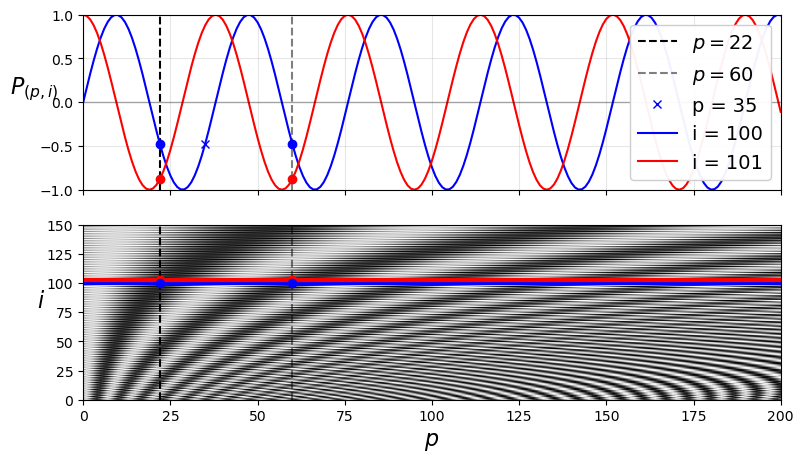

In [28]:
figure_max_length = 201
figure_embed_size = 512
pos_emb = PositionalEncoding(figure_max_length, figure_embed_size)
zeros = np.zeros((1, figure_max_length, figure_embed_size), np.float32)
P = pos_emb(zeros)[0].numpy()
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))

ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, P[p3, i1], "bx", label="p = {}".format(p3))
ax1.plot(P[:, i1], "b-", label="i = {}".format(i1))
ax1.plot(P[:, i2], "r-", label="i = {}".format(i2))
ax1.plot([p1, p2], [P[p1, i1], P[p2, i1]], "bo")
ax1.plot([p1, p2], [P[p1, i2], P[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(alpha=0.3)
ax1.hlines(0, 0, figure_max_length - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, figure_max_length - 1, -1, 1])

ax2.imshow(P.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, figure_max_length - 1, color="b", linewidth=3)
cheat = 2  # need to raise the red line a bit, else it ides the blue one
ax2.hlines(i2 + cheat, 0, figure_max_length - 1, color="r", linewidth=3)
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2 + cheat, i2 + cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, figure_max_length - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)

plt.show()